In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
df=pd.read_csv("cleaned_income_evaluation.csv")
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31950,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
31951,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
31952,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
31953,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## 1. Modeling: Random Forest

### 1. Pipeline and model definition

In [32]:
#Drop missing values in income column
#df=df.dropna(subset=['income'])

#Convert income to binary (<=50K:0,>50K:1)
df['income'] = df['income'].apply(lambda x: 0 if x.strip() == "<=50K" else 1)

#Identify numerical and categorical columns
numerical_features=["age","fnlwgt","education_num","capital_gain","capital_loss","hours_per_week"]
categorical_features=["workclass","education","marital_status","occupation","relationship","race","sex","native_country"]

#Convert categorical columns to type 'category'
#df[categorical_features]=df[categorical_features].astype("category")

print(df.head())

#Split into input (X) and output (Y) variables
X=df.drop(columns=["income"])
Y=df["income"]

#Numerical Processing: Handle NaN & Apply Z-Normalization
numerical_transformer=Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
#Categorical Processing: One-Hot Encoding
categorical_transformer=Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
#Combine transformations
preprocessor=ColumnTransformer([
    ("num",numerical_transformer,numerical_features),
    ("cat",categorical_transformer,categorical_features)
])
#Random Forest Model (hyperparameter tuning)
param_grid={
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}


   age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country  income  
0          2174             0              40  United-States       0  
1             0             0           

### 1.2. Model execution and hyperparameter tuning

In [33]:
#Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=42)

In [34]:
rf_pipeline=Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

#Perform Grid Search
grid_search=GridSearchCV(rf_pipeline,param_grid,cv=5,scoring='accuracy',n_jobs=-1)
grid_search.fit(X_train,Y_train)

#Predict using the best Random Forest model
y_pred_rf=grid_search.best_estimator_.predict(X_test)


In [35]:
#Calculate Accuracy
accuracy=accuracy_score(Y_test, y_pred_rf)
print(f"Accuracy: {accuracy:}")

#Print classification Report
print("Classification Report:")
print(classification_report(Y_test, y_pred_rf))

Accuracy: 0.8690345798779534
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4870
           1       0.78      0.63      0.70      1521

    accuracy                           0.87      6391
   macro avg       0.83      0.79      0.81      6391
weighted avg       0.86      0.87      0.86      6391



In [36]:
import pickle

with open("random-forest.pkl", "wb") as file:
    pickle.dump(grid_search, file)

with open("random-forest_preprocessor.pkl", "wb") as file:
    pickle.dump(preprocessor, file)

print(f"Best model saved")

Best model saved


### 1.3. Model validation and performance evaluation

In [37]:
# Generate confusion matrix
conf_matrix=confusion_matrix(Y_test, y_pred_rf)
print(conf_matrix)

[[4599  271]
 [ 566  955]]


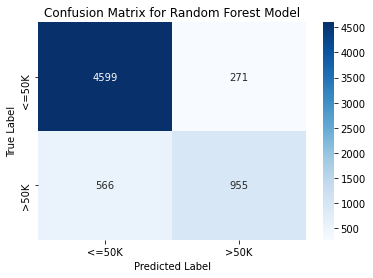

In [38]:
# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="Blues",xticklabels=["<=50K",">50K"],yticklabels=["<=50K",">50K"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Random Forest Model")
plt.show()